# Advanced Lane Finding Project

Steps:

- Compute camera calibration matrix and distortion coefficients using chessboard images
- Apply a distortion correction to raw images.
- Thresholding
- Perspective Transformation
- Finding Lane Lines
    

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
output_folder = 'output_images'

# 1) Compute the camera calibration using chessboard images

In [3]:
def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def camera_setup():
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    nx, ny = 9, 6
    cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist

cam_mtx, cam_dist = camera_setup()

# 2) Color Thresholding

In this step, we isolate the lightness and saturation channels of the color image and then take an absolute Sobel in the x direction of the lightness channel. Finally we compute a binary that activates a pixel if it's saturated pixel is within the hardcoded threshold OR if it's scaled Sobel pixel of the lightness channel is within a separate hardcoded threshold.

In [4]:

def pipeline(img,s_thresh=(170, 255), sx_thresh=(40, 120)):

    img = np.copy(img)
        
    # Convert to HLS color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient and color
    color_gradient_binary = np.zeros_like(s_channel)
    color_gradient_binary[((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) | ((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))] = 1
    return color_gradient_binary




# 3) Perspective Transformation

In [5]:
def perspective_transform(img, mtx, dist, isColor=True):

    xoffset = 50 # offset for dst points
    yoffset = 0
    img_size = (img.shape[1], img.shape[0])

   
    src = np.float32([(200, 700),(600, 450), (700,450),(1080, 700)])
  
   
    dst=np.float32([[350, 700], [350, 0],      [950, 0],[950, 700]]) 
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

# 4) Region of Interest (ROI) Method

In [6]:
def region_of_interest(img):
    """Extracts region of interest from an image.
    
    Args:
      img: Image from which to extract region of interest.
      roi_vertices: Numpy array of x,y points specifying region of interest.
    Returns:
      New image containing only the pixels within the region of interest.
    """
    height = img.shape[0]
    width = img.shape[1]
    roi_vertices = np.array([[(150,height),((int(width/2)-20), int(height*3/5)), 
        (int((width/2)+50), int(height*3/5)), (width-50,height)]], dtype=np.int32)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, roi_vertices, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img


# 5) Class For Tracking Right and Left Lane Curves

In [7]:
from collections import deque
class Line():
    def __init__(self,n=6,left=True):
        self.left=left
        #number of fits in buffer
        self.n_buffered = n
        # was the line detected in the last iteration?
        self.detected = False  
         # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]    
        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        #x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels.
        self.ally = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #number of dropped frames
        self.dropped_frames = 0
        
    def sanity_check_lane(self, R):
        """
        Checks new radius of curvature `R` against the radius stored in the object.
        """
        # Return true if there is no prior data
        if self.radius_of_curvature is None:
            return True

        R0 = self.radius_of_curvature
        self.insanity = abs(R-R0)/R0
        return self.insanity <= 0.8 # Max change from frame to frame is 200%
    
    def measure_curvature(self):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30.0/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = np.max(self.ally)
        fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])
        return curverad    
    
    def set_line_base_pos(self):
        #calculate car position
        y_eval = max(self.ally)
        fit=self.current_fit_coeffs
        self.line_pos = fit[0]*y_eval**2 +fit[1]*y_eval+ fit[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction
    
    def avgcoeffs(self):
        #calculate mean of fitting coefficients
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def fit_line(self,x,y):
        try:
        # Fit a second order polynomial to each
            fit = np.polyfit(y, x, 2)
            self.allx=x
            self.ally=y
            self.dropped_frames = 0
            rad_curv = self.measure_curvature()
            self.detected = self.sanity_check_lane(rad_curv)
            if self.detected:
            #    print("Detected")
                self.current_fit_coeffs=fit
                self.recent_fit_coeffs.appendleft(fit)
                self.dropped_frames = 0
                self.radius_of_curvature=rad_curv
                self.set_line_base_pos()
                self.avgcoeffs()
            else:
                self.dropped_frames +=1
                
        except:
            fit=None
            self.dropped_frames +=1
    
        
    def dectect_line_sliding_window(self,binary_warped):
        #code from Udacity lesson
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
          # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        if self.left:
            x_base=np.argmax(histogram[:midpoint])

        else:    
            x_base=np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        x_current=x_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        lane_inds=[]
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            win_x_low=x_current-margin
            win_x_high=x_current+margin

            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)  

        # Extract pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        self.fit_line(x,y)
       
        
    
    
    def dectect_line_fitted(self,binary_warped):
    #code from Udacity lesson
    # Identify the x and y positions of all nonzero pixels in the image based on previous fit
       # fit=self.current_fit_coeffs
        fit=self.avg_fit_coeffs 
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) & \
                     (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin))) 
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        self.fit_line(x,y)
    
    def dectect_line(self,binary_warped):
        if not(self.detected) and (self.dropped_frames>=n_buffered or self.dropped_frames==0):
            dectect_line_sliding_window(self,binary_warped)
        else:  
            dectect_line_fitted(self,binary_warped,fit)
            
   


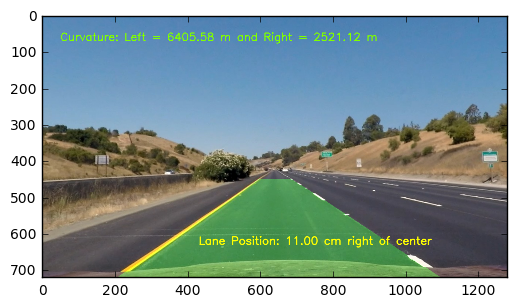

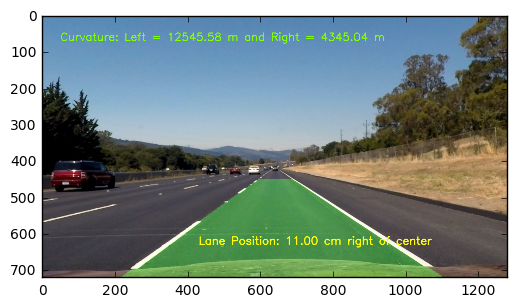

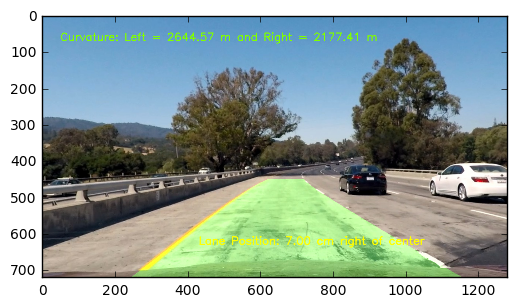

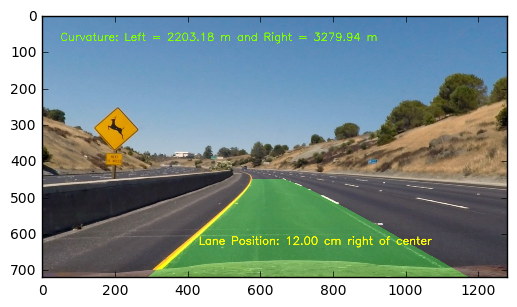

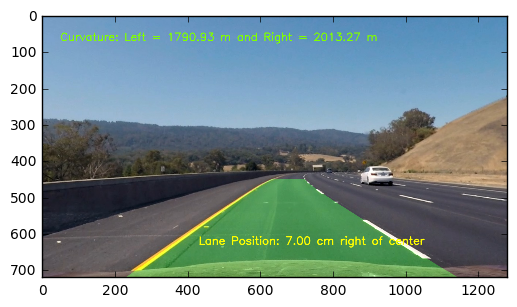

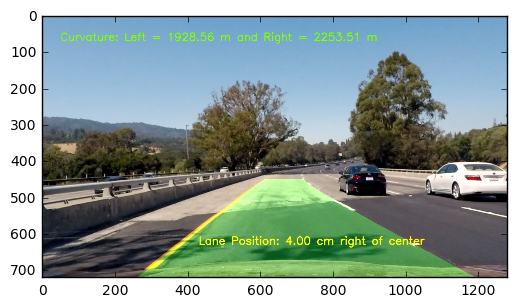

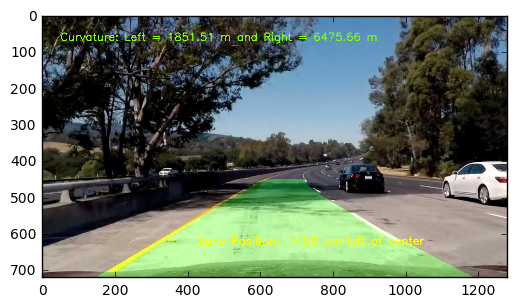

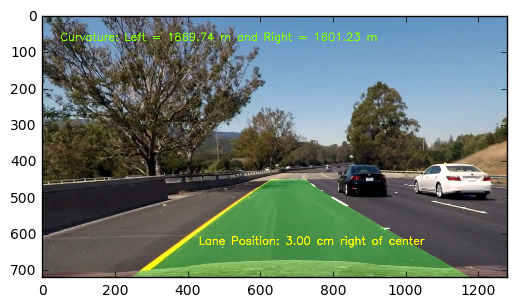

In [14]:
def create_result_image(undist,binary_warped,Minv,left_fit,right_fit):
    #from Udacity lesson
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def detect_lanes(img):
    global left_line
    global right_line
    undist = cv2.undistort(img,cam_mtx, cam_dist, None, cam_mtx)     
    combined = pipeline(undist)*255.0  
    roi_img=region_of_interest(combined)
    binary_warped, M,Minv = perspective_transform(roi_img, cam_mtx, cam_dist)
   
    left_line.dectect_line_sliding_window(binary_warped)    
    right_line.dectect_line_sliding_window(binary_warped)
 
  #  lane=create_result_image(undist,binary_warped,Minv,left_line.current_fit_coeffs,right_line.current_fit_coeffs)

    lane=create_result_image(undist,binary_warped,Minv,left_line.avg_fit_coeffs,right_line.avg_fit_coeffs)
    font = cv2.FONT_HERSHEY_SIMPLEX

    lane_width = 3.7
    offset = -100*round(0.5*(right_line.line_base_pos-lane_width/2) +  0.5*(abs(left_line.line_base_pos)-lane_width/2),2)

    if offset < 0:
        offset_text = 'Lane Position: {:.2f} cm left of center'.format(abs(offset))
    else:
        offset_text = 'Lane Position: {:.2f} cm right of center'.format(abs(offset))
    cv2.putText(lane,offset_text,(430,630), font, 1,(255,255,0),2,cv2.LINE_AA)

    curvature_text = 'Curvature: Left = {:.2f} m and Right = {:.2f} m'.format(left_line.radius_of_curvature, right_line.radius_of_curvature)
    cv2.putText(lane, curvature_text, (50,70), font, 1, (128,255,0), 2)
    return lane
    
images = ['straight_lines1.jpg','straight_lines2.jpg','test1.jpg','test2.jpg','test3.jpg','test4.jpg','test5.jpg','test6.jpg']

for i in range(len(images)):
    left_line=Line()
    right_line=Line(left=False)
    fname=images[i]
    img = cv2.imread('test_images/' + fname)  
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lane=detect_lanes(img)
    plt.imshow(lane)
    plt.show()
    lane_im=cv2.cvtColor(lane, cv2.COLOR_RGB2BGR)
    out_fname = os.path.join(output_folder, "lane_detect_%s"%os.path.basename(fname))
    cv2.imwrite(out_fname, lane_im)

In [9]:
test_output = 'result_project.mp4'
clip1 = VideoFileClip('project_video.mp4')
left_line=Line()
right_line=Line(left=False)
res_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time res_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video result_project.mp4
[MoviePy] Writing video result_project.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:52<00:00,  7.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project.mp4 

Wall time: 2min 52s


In [10]:
left_line=Line()
right_line=Line(left=False)

test_output = 'result_challenge.mp4'
clip1 = VideoFileClip('challenge_video.mp4')
res_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time res_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video result_challenge.mp4
[MoviePy] Writing video result_challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:01<00:00,  7.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_challenge.mp4 

Wall time: 1min 1s


In [11]:
left_line=Line()
right_line=Line(left=False)
test_output = 'result_harder_challenge.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4')
res_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time res_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video result_harder_challenge.mp4
[MoviePy] Writing video result_harder_challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [02:54<00:00,  7.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_harder_challenge.mp4 

Wall time: 2min 55s
